<a href="https://colab.research.google.com/github/HarryHy/RL-Practice/blob/main/DQN/Naive_DQN_and_Double_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import collections
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


In [3]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [4]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [5]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # Q(s, a) choose action from the Q network
        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        # Q(s, a) and r_t + gamma*Q(s', a*), next state's reward is from the target net
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [6]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

In [7]:
device

device(type='cuda')

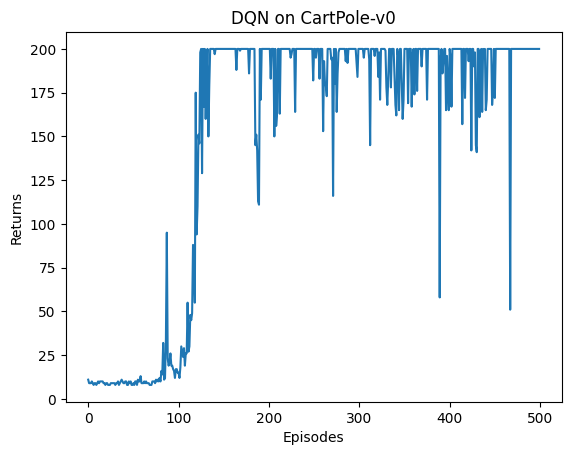

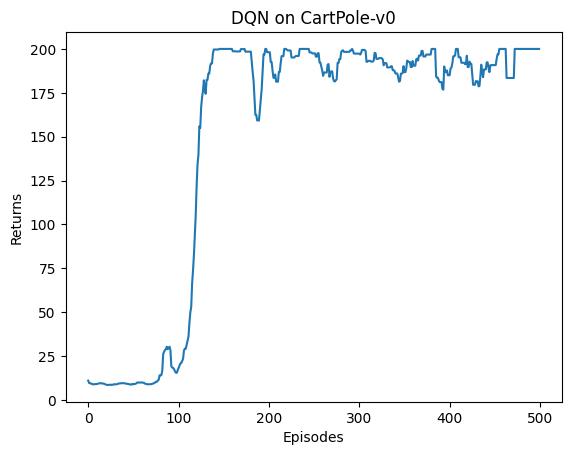

In [9]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [ ]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)

## DQN
### 1. training network
$Q_w$(s,a) close to $r + \gamma max_{a'}Q_{w}(s', a')$, ($s'$ is next state)

### 2. To train the network, set a target network $Q_{w^{-}}$

$Q_w$(s,a) close to $r + \gamma max_{a'}Q_{w^{-}}(s', a')$, ($s'$ is next state)

# Double DQN

## DQN
### 1. training network
$Q_w$(s,a) close to $r + \gamma max_{a'}Q_{w}(s', a')$, ($s'$ is next state)

### 2. To train the network, set a target network $Q_{w^{-}}$

$Q_w$(s,a) close to $r + \gamma max_{a'}Q_{w^{-}}(s', a')$, ($s'$ is next state)

## Double DQN

when choosing the $max_{a'}$, choose it from another network (not the $Q_{w^{-}}$) to avoid over estimation.

$Q_w$(s,a) close to $r + \gamma max_{a'}Q_{w^{-}}(s', a')$, ($s'$ is next state) is changed to

$Q_w$(s,a) close to $r + \gamma Q_{w^{-}}(s', max_{a'}Q_{w}(s', a'))$, the action is based on the training network

In [20]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm


class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [24]:
class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            # the action is chosen from the training network
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else: # DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [25]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

In [26]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s, episode=200, return=-332.256]


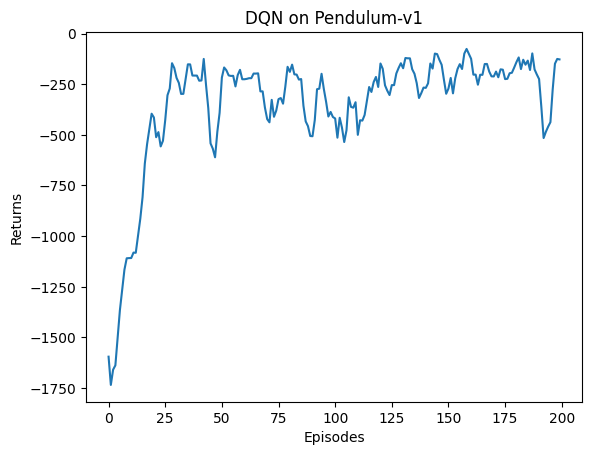

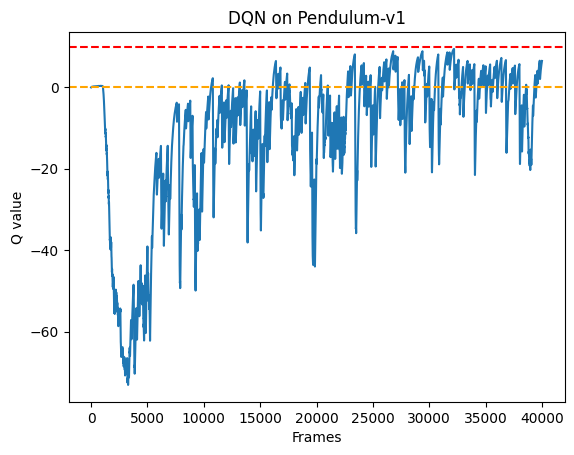

In [27]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s, episode=200, return=-290.263]


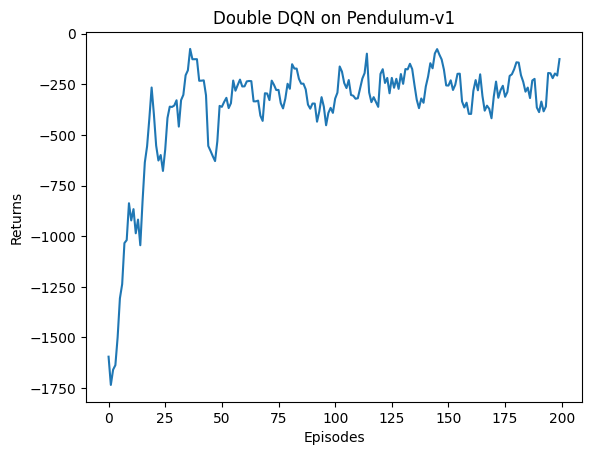

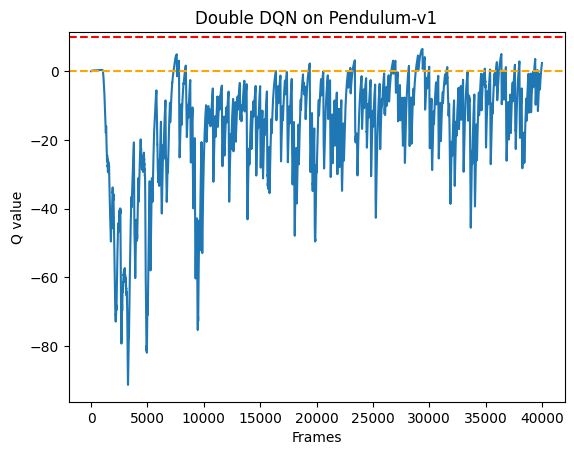

In [28]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

# Duel DQN

Iteration 9: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, episode=200, return=-223.518]


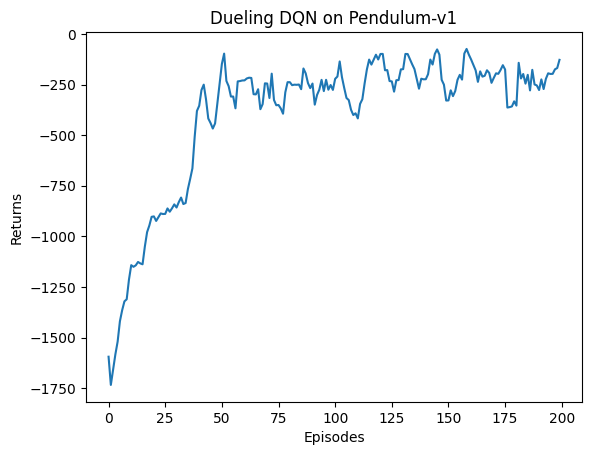

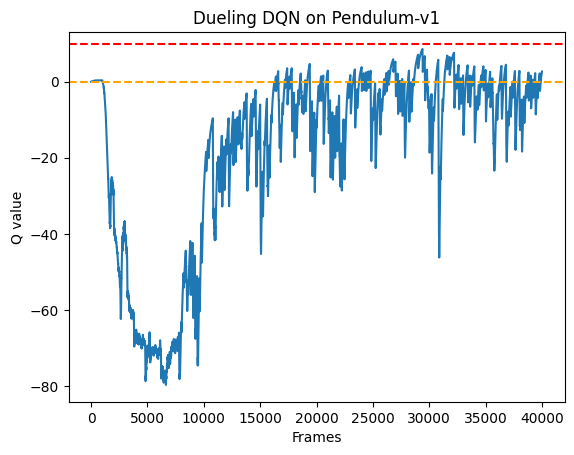

In [29]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q


class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()